# About

Implement a machine learning algorithm with gradient descent on a neuronal population model with delays, in order to find an optimal matrix of delay distribution such that the objective function $L(r)$ is maximized. This script implements the learning algorithm on the actual setting.

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
from scipy.spatial import distance
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import matplotlib.colors as clr
import pandas as pd
from tqdm.notebook import tqdm
import math
from math import pi


from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Determine export folder name here:
foldername = os.path.join(os.getcwd(), 'data', 'matrices', 'ICBM')
filename_names = os.path.join(foldername, 'freesurfer_regions_68_sort_full.txt')
filename_pos = os.path.join(foldername, 'fs_region_centers_68_sort.txt')
filename_conn = os.path.join(foldername, 'icbm_fiber_mat.txt')

# Import data

In [3]:
# Data import
W_raw = np.loadtxt(fname = filename_conn) # Connections
pos = np.loadtxt(fname = filename_pos) # Positions of nodes

# Process imports
dist = distance.cdist(pos,pos,'euclidean')
# dist = dist / 1000 # Convert from millimeters to meters (length of brain is 15cm, max dist is 160)
W = W_raw / np.max(W_raw)
N = W.shape[0]

# Normalized weights
W_sum = np.sum(W, 0)
W_norm = W / W_sum[:,np.newaxis]

# Initial delays and velocities
vel0 = 1.1*np.ones((N,N)) # Initial, non-random velocities
# vel0 = np.random.uniform(low=0.5, high=2.0, size=(N,N)) # Initial (unmyelinated) velocities
tau0 = dist / vel0
r0 = 0.1*np.ones(N) # Baseline firing rate

# Parameters

In [4]:
eta = 2.0
numIters = 100
kappa = 3**2 

# Employ learning model

In [5]:
time = range(numIters)

# Set up arrays
obj_arr = np.zeros(numIters+1)
stab_arr = np.zeros(numIters+1)
tau_arr = np.zeros((numIters+1, N**2))
vel_arr = np.zeros((numIters+1, N**2))
grad_arr = np.zeros((numIters, N**2))

# Initialize
r_i = r0
tau = tau0
vel = vel0

tau_arr[0] = np.reshape(tau0, -1)
vel_arr[0] = np.reshape(vel0, -1)
obj_arr[0] = FunLib.objectiveFun(r0)

# Non-zero connections
W_inds = np.where(W != 0)

# MAIN LOOP
for i in tqdm(time):
    
    gamma = FunLib.coincidenceFactorND(kappa, W_norm, tau)
    
    # Determine the equilibrium solution using current delays
    r_i = np.linalg.solve(np.identity(N) - W*gamma/N, r0)
    
    # Stability
    eigs = np.linalg.eig(W*gamma/N - np.eye(N))
    
    # Obtain gradient:
    gradL = np.zeros((N,N))
    for k in range(W_inds[0].size):
        ind = (W_inds[0][k], W_inds[1][k])
        gradL[ind[0], ind[1]] = FunLib.derivObjectiveTauND(W, W_norm, tau, kappa, gamma, r_i, ind)
    
    # Apply gradient onto velocities:
    gradL_vel = gradL * (-dist / vel**2)
    vel = vel + eta * gradL_vel
    tau = dist / vel
    
    # Store functions
    obj_arr[i+1] = FunLib.objectiveFun(r_i)
    vel_arr[i+1] = np.reshape(vel, -1)
    tau_arr[i+1] = np.reshape(tau, -1)
    grad_arr[i] = np.reshape(gradL_vel, -1)
    stab_arr[i] = np.max(np.real(eigs[0]))

  0%|          | 0/100 [00:00<?, ?it/s]

# Figures

## Objective over iterations

(0, 100)

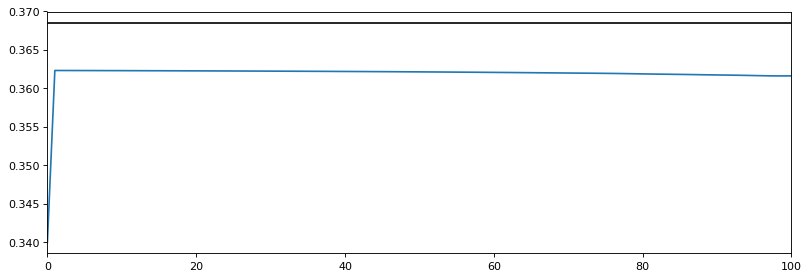

In [6]:
# Maximal objective:
r_iMax = np.linalg.solve(np.identity(N) - W*np.ones(W.shape)/N, r0)
objMax = FunLib.objectiveFun(r_iMax)

fig, ax = plt.subplots(1, figsize=(12,4), dpi=80)
iters = np.arange(numIters+1)
ax.plot(iters, obj_arr)
ax.axhline(objMax, color='black')
ax.set_xlim(left=0, right=numIters)

## Delays, velocities over time

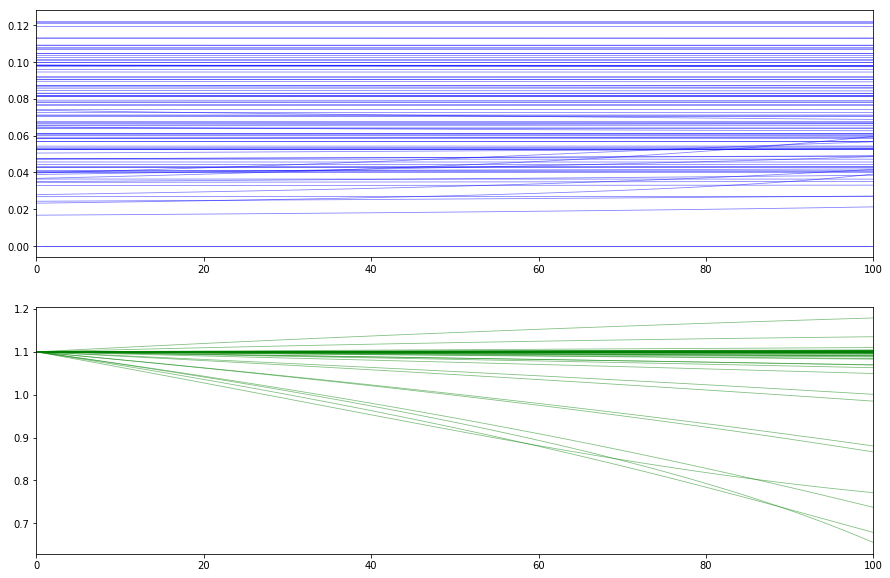

In [7]:
# Options
lw1 = 0.8
alp1 = 0.5
iters = np.arange(numIters+1)
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].plot(iters, tau_arr[:,:103], linewidth=lw1, alpha=alp1, color='blue')
axs[1].plot(iters, vel_arr[:,:103], linewidth=lw1, alpha=alp1, color='green')

for i in range(len(axs)):
    axs[i].set_xlim(left=0, right=numIters)

## Gradient over time

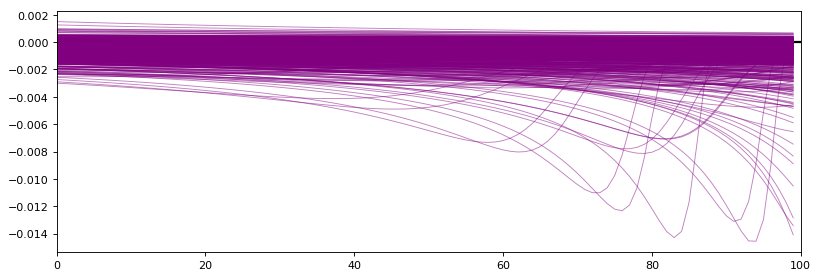

In [8]:
fig, ax = plt.subplots(1, figsize=(12,4), dpi=80)
iters = np.arange(numIters)
ax.plot(iters, grad_arr * np.reshape(W != 0, -1), linewidth=lw1, alpha=alp1, color='purple')
ax.set_xlim(left=0, right=numIters)
ax.axhline(y=0, color='black', linewidth=2.0, zorder=1)

## Connections

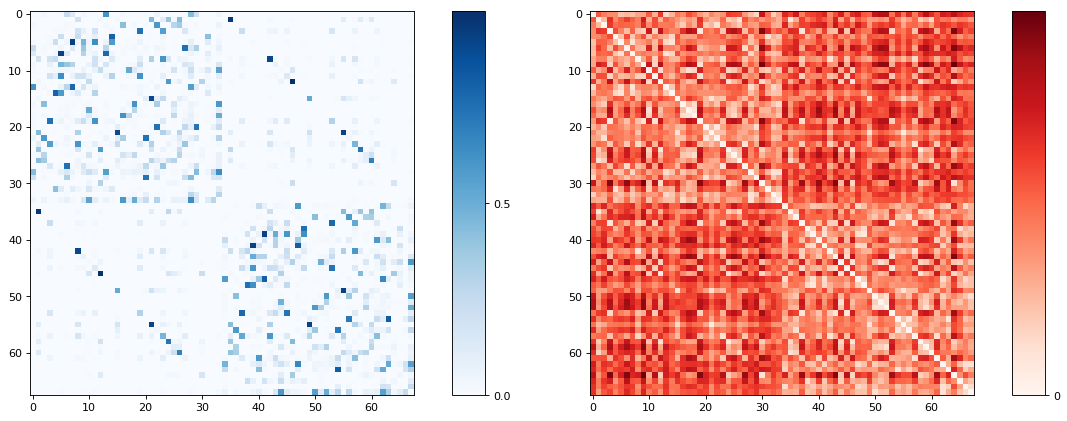

In [9]:
# Positions [left, bottom, width, height] 
bbox0 = [0.05, 0.1, 0.35, 0.80]
bbox1 = [0.43, 0.1, 0.03, 0.80]
bbox2 = [0.55, 0.1, 0.35, 0.80]
bbox3 = [0.93, 0.1, 0.03, 0.80]

fig, ax = plt.subplots(4, figsize=(14,6), dpi=80)

ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

cs1 = ax[0].imshow(W, cmap='Blues')
cs2 = ax[2].imshow(tau0, cmap='Reds')

# Colour bars
ticks1 = np.arange(0, np.max(W), 0.5) # Connectivity strength
ticks2 = np.arange(0, np.max(tau0), 0.5) # Delays

fig.colorbar(cs1, cax=ax[1], ticks=ticks1)
fig.colorbar(cs2, cax=ax[3], ticks=ticks2)

# Statistics

## Parameters

In [10]:
var_name1 = ['N', 
            r'Scaling factor $\kappa$', 
            r'Myelination rate $\eta$', 
            r'Baseline firing rate $r_i^0$',
            r'Distance $\ell$'
            ]

var_value1 = [N, kappa, eta, r0[0], np.mean(dist)]

var_name1 = np.array(var_name1)
var_value1 = np.array(var_value1)

table1 = pd.DataFrame({'Variable' : var_name1, 'Value': var_value1})

# Display
table1.style

,Variable,Value
0,N,68
1,Scaling factor $\kappa$,0.0009
2,Myelination rate $\eta$,2
3,Baseline firing rate $r_i^0$,0.1
4,Distance $\ell$,0.0780494


## Processed data

In [11]:
vel_arr[:,:100].shape

(101, 100)